In [2]:
import os
import keras
import numpy as np
from glob import glob
from tqdm import tqdm
import tensorflow as tf
import pandas as pd

# Data
from keras.preprocessing.image import ImageDataGenerator

# Data VIz
import plotly.express as px
import matplotlib.pyplot as plt

# Model
from keras import Sequential
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import load_model

# Transfer Learning
from tensorflow.keras.applications import Xception

# Callbacks
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from PIL import Image
from pathlib import Path
import os.path

Reading and Understanding the data

In [3]:
root_path = '/content/drive/MyDrive/TY BTech Sem-5/ML Project/YogaPoses'
image_dir = Path(root_path)

# The folder names are our Classes
class_names = sorted(os.listdir(root_path))

# Check if 'Poses.json' is in the list before attempting to remove it
if 'Poses.json' in class_names:
    class_names.remove('Poses.json')
else:
    print("'Poses.json' not found in the list.")

n_classes = len(class_names)

print(f"Total Number of Classes: {n_classes}")
print(f"Classes: \n{class_names}")

'Poses.json' not found in the list.
Total Number of Classes: 5
Classes: 
['Downdog', 'Goddess', 'Plank', 'Tree', 'Warrior2']


The above code gives all the distinct categories (here Yoga Poses) in present in the dataset.

In [4]:
filepath = list(image_dir.glob(r'**/*.jpg'))
label = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepath))

In [5]:
filepath = pd.Series(filepath, name='Filepath').astype(str)
label = pd.Series(label, name='Label')
image_df = pd.concat([filepath, label], axis=1).sample(frac=1.0, random_state=1).reset_index(drop=True)

image_df.head()

,Filepath,Label
0,/content/drive/MyDrive/TY BTech Sem-5/ML Proje...,Plank
1,/content/drive/MyDrive/TY BTech Sem-5/ML Proje...,Tree
2,/content/drive/MyDrive/TY BTech Sem-5/ML Proje...,Downdog
3,/content/drive/MyDrive/TY BTech Sem-5/ML Proje...,Plank
4,/content/drive/MyDrive/TY BTech Sem-5/ML Proje...,Goddess


In [6]:
class_dis = [len(os.listdir(root_path + f"/{name}")) for name in class_names]
print(class_dis)

[196, 199, 197, 198, 198]


From this we understand that there how many data objects (here, images) of each feature are there in the dataset



1.   Down dog - 196 images
2.   Goddess - 199 images
3.   Plank - 197 images
4.   Tree - 198 images
5.   Warrior2 - 198 images




Visualizing this data for better understanding

In [7]:
fig = px.pie(names=class_names, values=class_dis, title="Class Distribution",)
fig.update_layout({'title':{'x':0.5}})
fig.show()

Since all the Yoga Pose categories have nearly equal number of data objects, problems like class imbalance which lead to biased results and reduced performance.

In [8]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(image_df, test_size = 0.2,random_state = 33, shuffle=True)

Dividing dataset in trainng and testing sets

In [9]:
# Initialize data generator
data_gen = ImageDataGenerator(
    rotation_range=20,
    validation_split=0.4,
    rescale=1./255
)

test_gen = ImageDataGenerator(rescale=1./255)

# Load Data
train_ds = data_gen.flow_from_dataframe(train_df,x_col = 'Filepath',y_col= 'Label', target_size=(256,256), class_mode='categorical', subset='training')
valid_ds = data_gen.flow_from_dataframe(train_df,x_col = 'Filepath',y_col= 'Label', target_size=(256,256), class_mode='categorical', subset='validation')
test_ds = test_gen.flow_from_dataframe(test_df,x_col = 'Filepath',y_col= 'Label', target_size=(256,256), class_mode='categorical')

Found 474 validated image filenames belonging to 5 classes.
Found 316 validated image filenames belonging to 5 classes.
Found 198 validated image filenames belonging to 5 classes.


In [10]:
def show_image(image, title=None):
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')

After splitting training set looks as follows:

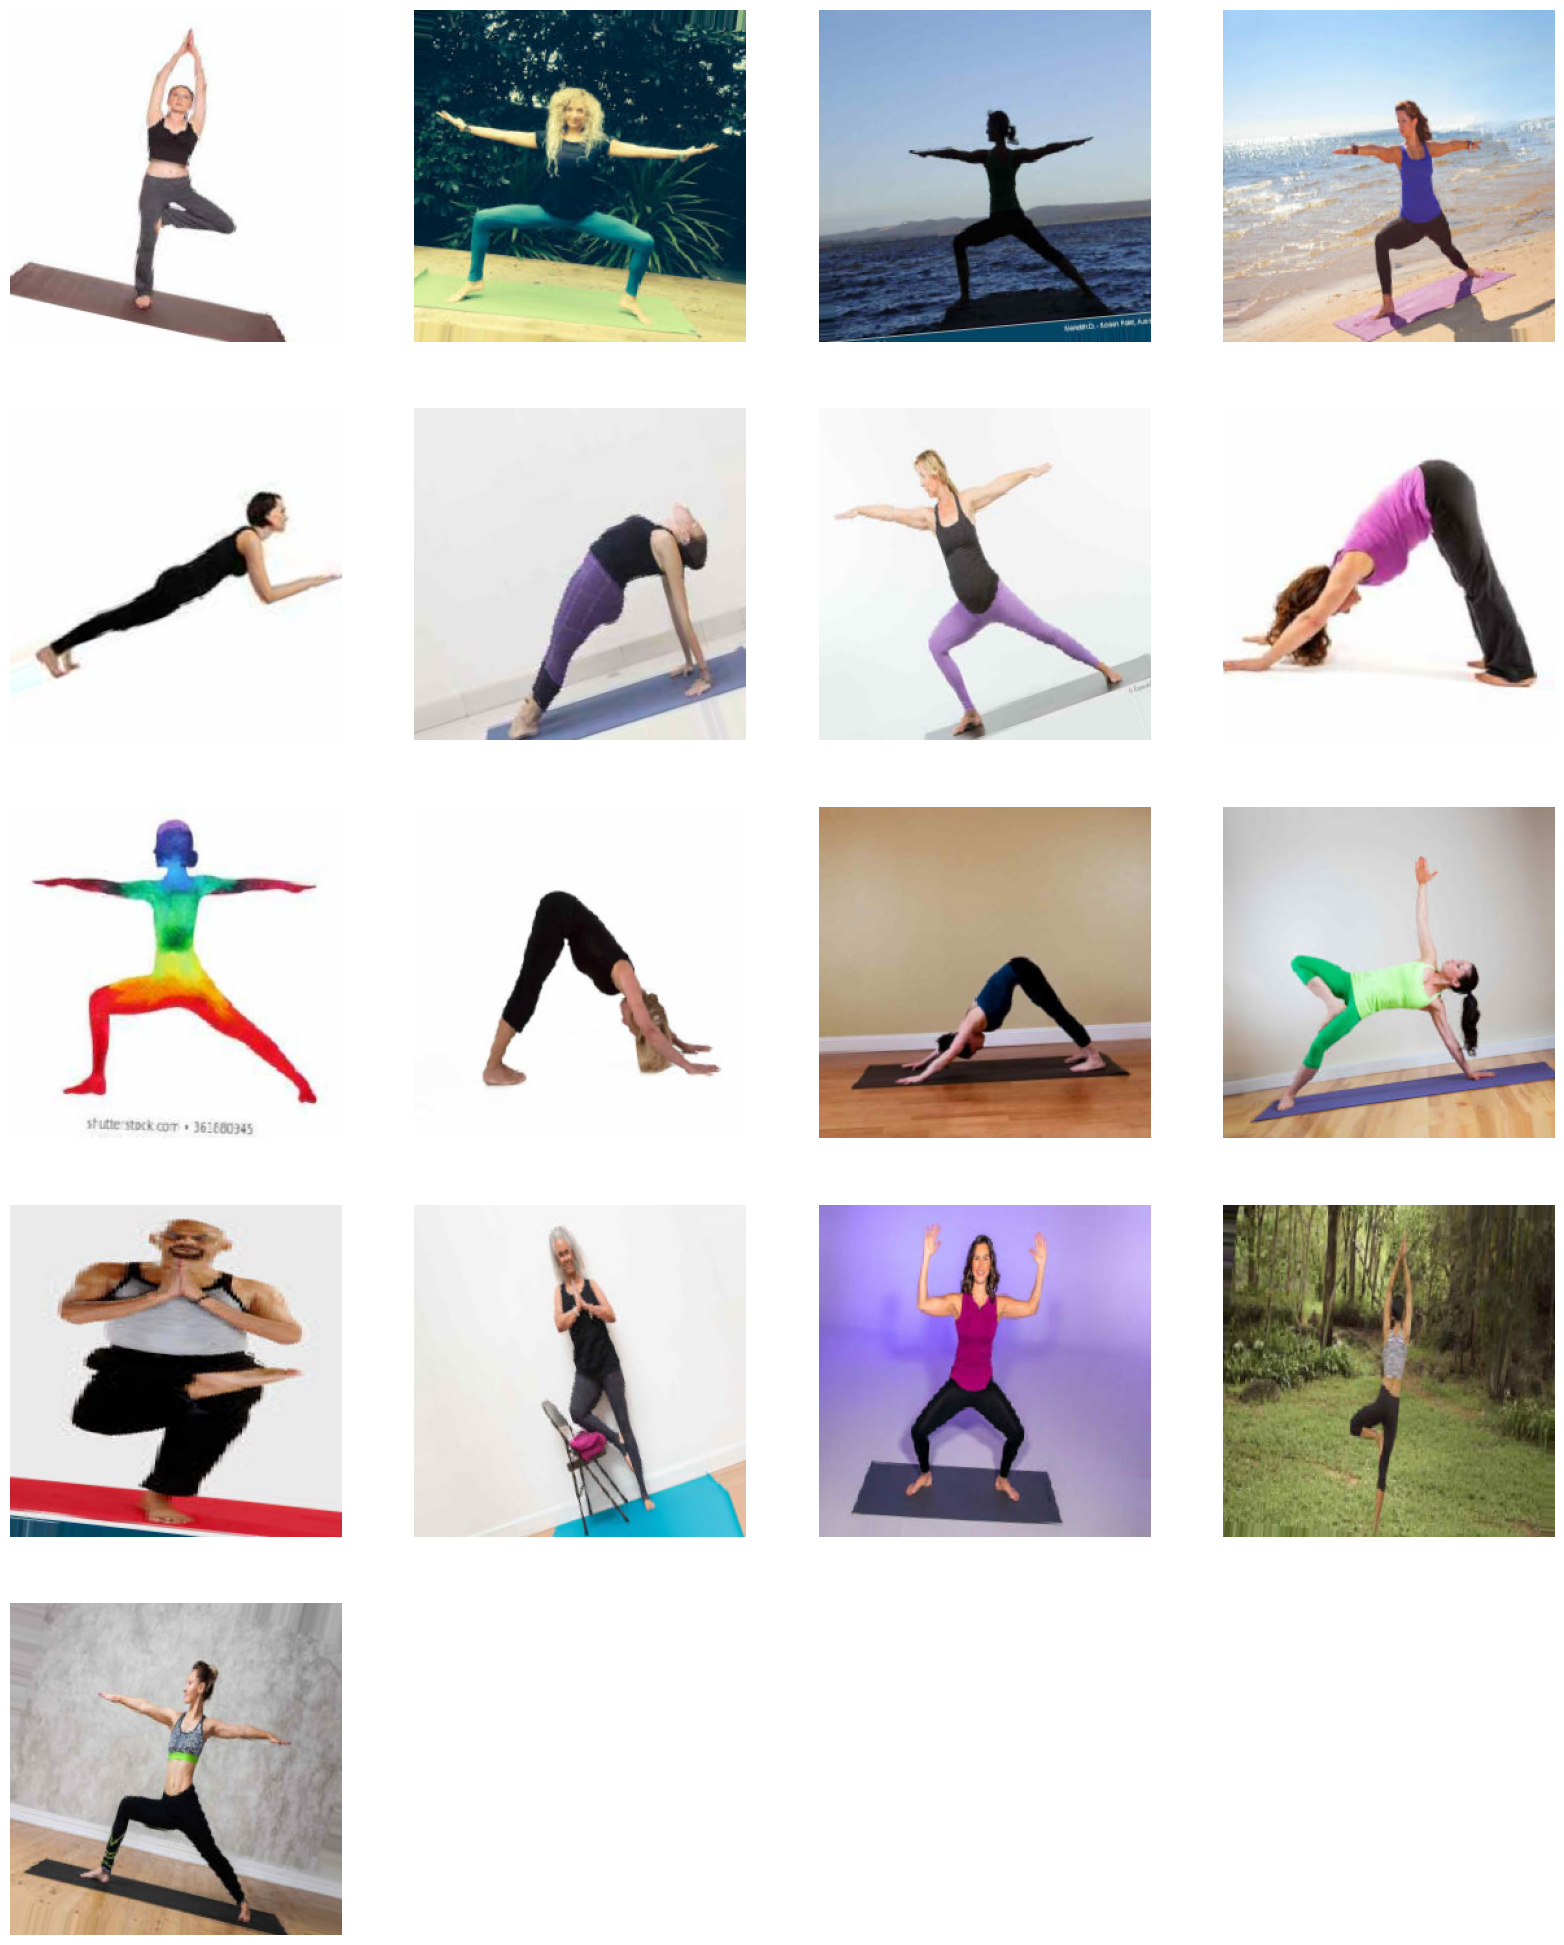

In [11]:
n = 1
plt.figure(figsize=(20,25))
for images, labels in train_ds:
    plt.subplot(5,4,n)
    show_image(images[n])
    n+=1
    if n>=18:
        break
plt.show()

Convolutional Neural Network: Xception

Loading Xception model (excluding the top classification layer and freezing the weights of the pre-trained layer)

In [12]:
# Loading Xception for TRansfer-Learning
base_model = Xception(include_top=False, weights='imagenet',input_shape=(256,256,3))
base_model.trainable=False

83683744/83683744 [==============================] - 5s 0us/step


Transfer learning: the reuse of a pre-trained model on a new problem/ learning from previous tasks

In [13]:
# Model Architecture
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),         #for reducing dimensions
    Dense(256, activation='relu'),     #for introducing non-linearity
    Dropout(0.4),                      #to prevent overfitting
    Dense(n_classes, activation='softmax')       #to convert the network's output into probability distributions over the classes.
])

# Compiling Model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


# Callbacks
callbacks = [EarlyStopping(patience=3, restore_best_weights=True)]    #stop training when monitored metric stops improving

In [14]:
history = model.fit(
     train_ds,
     validation_data=valid_ds,
     epochs=10,
     callbacks=callbacks
 )

Epoch 1/10
15/15 [==============================] - 224s 15s/step - loss: 1.2194 - accuracy: 0.5485 - val_loss: 0.7694 - val_accuracy: 0.7373
Epoch 2/10
15/15 [==============================] - 16s 1s/step - loss: 0.6478 - accuracy: 0.7785 - val_loss: 0.5149 - val_accuracy: 0.8291
Epoch 3/10
15/15 [==============================] - 16s 1s/step - loss: 0.4584 - accuracy: 0.8439 - val_loss: 0.4338 - val_accuracy: 0.8608
Epoch 4/10
15/15 [==============================] - 20s 1s/step - loss: 0.2992 - accuracy: 0.9093 - val_loss: 0.4016 - val_accuracy: 0.8671
Epoch 5/10
15/15 [==============================] - 16s 1s/step - loss: 0.2423 - accuracy: 0.9283 - val_loss: 0.3407 - val_accuracy: 0.8924
Epoch 6/10
15/15 [==============================] - 15s 1s/step - loss: 0.2100 - accuracy: 0.9473 - val_loss: 0.2870 - val_accuracy: 0.9051
Epoch 7/10
15/15 [==============================] - 16s 1s/step - loss: 0.1763 - accuracy: 0.9557 - val_loss: 0.2770 - val_accuracy: 0.9146
Epoch 8/10
15/15 [

Evaluating the model on validation (testing) set

In [15]:
model.evaluate(test_ds)

7/7 [==============================] - 114s 19s/step - loss: 0.2411 - accuracy: 0.9091


[0.24113653600215912, 0.9090909361839294]

This Xception Model when used on given dataset for Yoga Pose Detection gives 90.91% accuracy.

Text(0.5, 1.0, 'Training and Validation Accuracy')

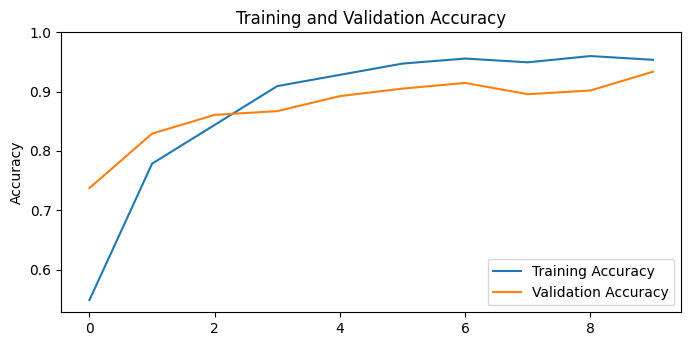

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 21387309 (81.59 MB)
Trainable params: 525829 (2.01 MB)
Non-trainable params: 20861480 (79.58 MB)
___________

In [17]:
pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 20.9 MB/s eta 0:00:00


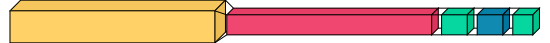

In [18]:
import visualkeras
visualkeras.layered_view(model)